SET UP DATASET VIA KAGGLE API

In [54]:
!pip install kaggle

In [55]:
from google.colab import files

# Upload the Kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [56]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [57]:
!kaggle datasets download -d shanegerami/ai-vs-human-text

ai-vs-human-text.zip: Skipping, found more recently modified local copy (use --force to force download)


In [58]:
!unzip ai-vs-human-text.zip

Archive:  ai-vs-human-text.zip
replace AI_Human.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

SET UP THE ENVIRONNEMENT

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [60]:
dataset = pd.read_csv("/content/AI_Human.csv")
dataset.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [61]:
dataset.tail()

,text,generated
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0
487234,"Richard Non, Jimmy Carter, and Bob Dole and ot...",0.0


-*Observation*:
we could observe that the dataset is shuffle.

In [62]:
dataset[dataset["generated"] == 1].count()

text         181438
generated    181438
dtype: int64

In [63]:
dataset[dataset["generated"] == 0].count()

text         305797
generated    305797
dtype: int64

-*Observation*:

There is double data that are generated by human than AI.

I think that because of this that the system can be biased.

In [64]:
dataset['length'] = dataset['text'].apply(len)

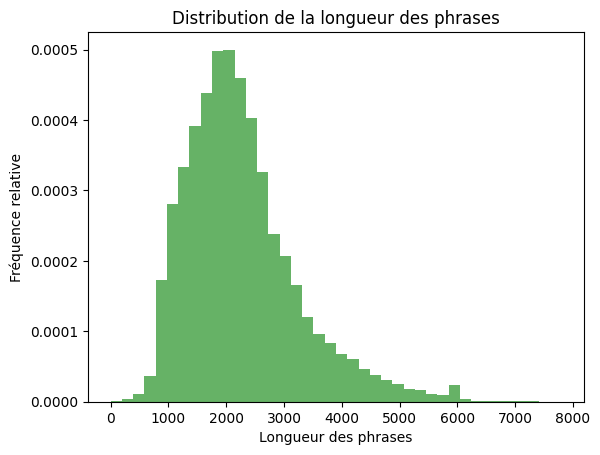

In [65]:
plt.hist(dataset['length'], bins=40, density=True, alpha=0.6, color='g',  range=(0, 7800))


plt.title('Distribution de la longueur des phrases')
plt.xlabel('Longueur des phrases')
plt.ylabel('Fréquence relative')
plt.show()

In [66]:
length_counts = dataset["length"].value_counts()
print(length_counts)


1974    320
1942    303
2082    303
1855    302
2048    296
       ... 
555       1
8436      1
5236      1
6117      1
6320      1
Name: length, Length: 6419, dtype: int64


-Observation:

I think that i will limited the AI model to 1974 words

In [67]:
dataset.count()

text         487235
generated    487235
length       487235
dtype: int64

In [68]:
dataset_human = dataset[dataset['generated']==0]
dataset_ai = dataset[dataset['generated']==1]

In [69]:
x_human = dataset_human["text"][0:20000]
x_ai = dataset_ai["text"][0:20000]
y_human = dataset_human["generated"][0:20000]
y_ai = dataset_ai["generated"][0:20000]

In [70]:
x_human.head()

0    Cars. Cars have been around since they became ...
1    Transportation is a large necessity in most co...
2    "America's love affair with it's vehicles seem...
3    How often do you ride in a car? Do you drive a...
4    Cars are a wonderful thing. They are perhaps o...
Name: text, dtype: object

In [71]:
x_ai.head()

704     This essay will analyze, discuss and prove one...
740     I strongly believe that the Electoral College ...
1262    Limiting car use causes pollution, increases c...
1378    Car-free cities have become a subject of incre...
1379    Car Free Cities  Car-free cities, a concept ga...
Name: text, dtype: object

In [72]:
x_human_reset = x_human.reset_index(drop=True)
x_ai_reset = x_ai.reset_index(drop=True)

x = pd.concat([x_human_reset, x_ai_reset], ignore_index=True)
y = pd.concat([y_human, y_ai], ignore_index=True)

In [73]:
x.tail()

39995    Title: A Cowboy Who Rode the Waves\n\nIntroduc...
39996    Car-free cities are becoming a trending topic ...
39997    The Electoral College is a unique system used ...
39998    Venus, the second planet from the sun, is ofte...
39999    The Face on Mars, also known as the Martian Fa...
Name: text, dtype: object

In [74]:
y.tail()

39995    1.0
39996    1.0
39997    1.0
39998    1.0
39999    1.0
Name: generated, dtype: float64

In [75]:
from sklearn.utils import shuffle
random_seed = 42
# Combine x and y into a single DataFrame
combined_data = pd.concat([x, y], axis=1)

# Shuffle the combined DataFrame
shuffled_data = shuffle(combined_data, random_state=random_seed)
x_shuffled = shuffled_data["text"]
y_shuffled = shuffled_data["generated"]
x_train = x_shuffled[0:int(70/100*x_shuffled.count())]
x_test = x_shuffled[int(70/100*x_shuffled.count()):]
y_train = y_shuffled[0:int(70/100*x_shuffled.count())]
y_test = y_shuffled[int(70/100*x_shuffled.count()):]

In [76]:
x_test.head()

17488    Many people today are accepting the idea of li...
18677    People think about today's world as the era of...
28140    In the Chinese culture, it is common for famil...
10033    I don't think its Aliens, it has to be the way...
7273     New technology is being made all around the wo...
Name: text, dtype: object


vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = ""
training_size = 20000

In [77]:
tokenizer = Tokenizer(num_words=100000, oov_token = "<OOV>")
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [78]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences, maxlen = 500,
                                padding = "post", truncating = "post")
test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, maxlen = 500,
                                padding = "post", truncating = "post")

In [80]:
from keras.callbacks import EarlyStopping

# Définir le callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(100000, 16, input_length = 500),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(1,activation = "sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])

training_padded = np.array(training_padded)
training_labels = np.array(y_train)
testing_padded = np.array(test_padded)
testing_labels = np.array(y_test)
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stopping], verbose=2)

Epoch 1/30
875/875 - 26s - loss: 0.2052 - accuracy: 0.9490 - val_loss: 0.0462 - val_accuracy: 0.9895 - 26s/epoch - 30ms/step
Epoch 2/30
875/875 - 22s - loss: 0.0332 - accuracy: 0.9916 - val_loss: 0.0273 - val_accuracy: 0.9933 - 22s/epoch - 25ms/step
Epoch 3/30
875/875 - 23s - loss: 0.0175 - accuracy: 0.9956 - val_loss: 0.0161 - val_accuracy: 0.9953 - 23s/epoch - 27ms/step
Epoch 4/30
875/875 - 22s - loss: 0.0082 - accuracy: 0.9979 - val_loss: 0.0103 - val_accuracy: 0.9969 - 22s/epoch - 25ms/step
Epoch 5/30
875/875 - 21s - loss: 0.0040 - accuracy: 0.9994 - val_loss: 0.0088 - val_accuracy: 0.9977 - 21s/epoch - 24ms/step
Epoch 6/30
875/875 - 23s - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.0081 - val_accuracy: 0.9977 - 23s/epoch - 26ms/step
Epoch 7/30
875/875 - 23s - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0081 - val_accuracy: 0.9977 - 23s/epoch - 26ms/step
Epoch 8/30
875/875 - 21s - loss: 6.4132e-04 - accuracy: 0.9999 - val_loss: 0.0088 - val_accuracy: 0.9974 - 21s/epoch - 24ms/s

In [101]:
x_human_validation = dataset_human["text"][20000:40000]
x_ai_validation = dataset_ai["text"][20000:40000]
y_human_validation = dataset_human["generated"][20000:40000]
y_ai_validation = dataset_ai["generated"][20000:40000]

x_validation = pd.concat([x_human_validation,y_human_validation], ignore_index= True)
y_validation = pd.concat([y_human_validation, y_ai_validation], ignore_index=True)

combined_data_validation = pd.concat([x_validation, y_validation], axis=1)

# Shuffle the combined DataFrame
shuffled_data_validation = shuffle(combined_data_validation, random_state=random_seed)

# Reset index to ensure that column titles are preserved
shuffled_data_validation.reset_index(drop=True, inplace=True)

x_shuffled_validation = shuffled_data_validation.iloc[:, 0]
y_shuffled_validation = shuffled_data_validation.iloc[:, 1]
sequences_validation = tokenizer.texts_to_sequences(x_shuffled_validation.astype("str"))

padded_validation = pad_sequences(sequences_validation, maxlen = 500,
                       padding = "post",
                       truncating = "post")
results = model.evaluate(padded_validation, y_validation)

# Affichez les résultats (par exemple, la perte et la précision)
print("Loss:", results[0])
print("Accuracy:", results[1])

1250/1250 [==============================] - 4s 2ms/step - loss: 3.4931 - accuracy: 0.5006
Loss: 3.4930965900421143
Accuracy: 0.5006250143051147
